In [79]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy
import astropy.units as u
import astropy.constants as ac
import sunpy.map
import sunpy.visualization.colormaps as cm
import skimage
import glob
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import random

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers


import autoenc_model as aem
import data_generator as dg
import utils
import json

import umap

from mpl_toolkits.mplot3d import Axes3D

import ipywidgets as widgets
import open3d as o3d

import datetime
from tqdm.notebook import tqdm



In [32]:
latent_size = 1024
batch_size = 48
# gen_input = dg.MultiChannelAEGenerator("data/composite_data/", batch_size, test_split=0.2, shuffle=True, noise_filter=True)
gen_input = dg.MultiChannelAEGenerator("data/composite_data/", batch_size, test_split=0.2, shuffle=True, noise_filter=True)

25650
22501


/home/eugeniolr/Documents/master/TFM/data_generator.py:188: RuntimeWarning: All-NaN slice encountered
  min_values = np.nanmin(np.nanmin(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:189: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:197: RuntimeWarning: All-NaN slice encountered
  hmi_max_values = np.nanmax(np.nanmax(np.abs(data_matrix[:,:,:,2]), axis=2, keepdims=True), axis=1, keepdims=True)


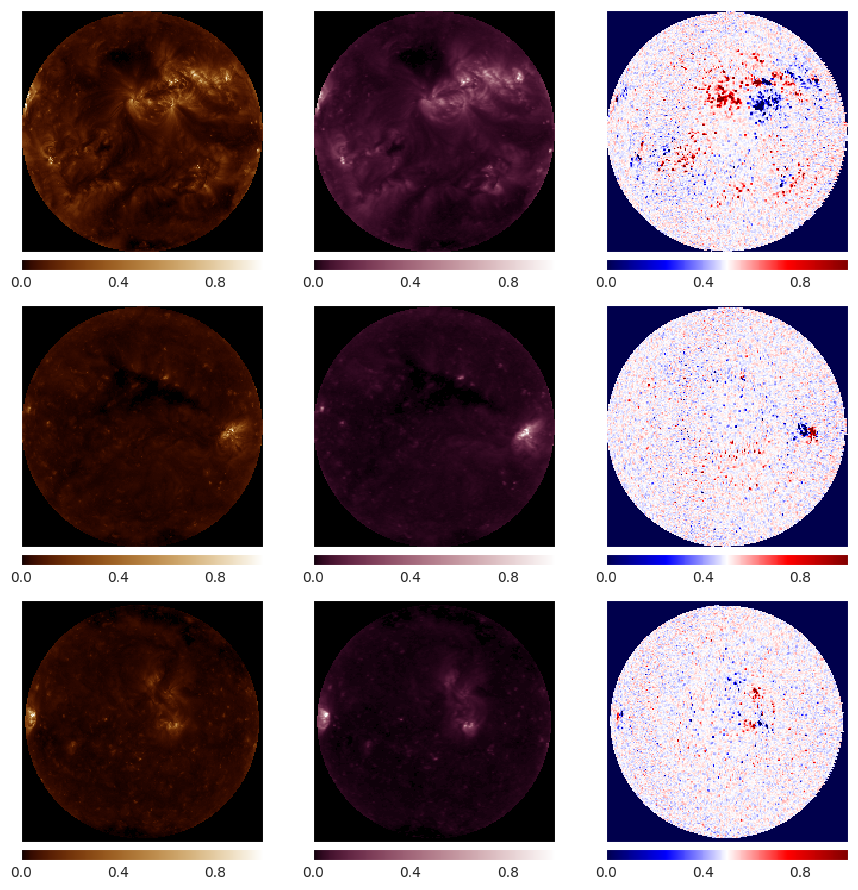

In [33]:
img_amount = 3

sample_images = gen_input.sample(img_amount)

image_list = []
for data_image in sample_images:
    for channel in data_image.transpose(2,0,1):
        image_list.append(channel)

isns.ImageGrid(image_list, cmap=["sdoaia193", "sdoaia211", "seismic"]*img_amount, orientation="h", vmin=0, vmax=1)


In [34]:
print("train using the script")
# latent_size = 1024
# # optimizer = keras.optimizers.Adam(learning_rate=0.001)
# # optimizer = keras.optimizers.SGD(learning_rate=0.01)
# optimizer = keras.optimizers.RMSprop(learning_rate=0.001)

# loss_fn = "mse"

# autoencoder, encoder, decoder = aem.gen_xception_autoenc_3c(latent_size, optim=optimizer, loss=loss_fn)

train using the script


In [35]:
print("train using the script")
# n_epochs = 1

# history = autoencoder.fit(gen_input, epochs=n_epochs)

train using the script


In [36]:
print("train using the script")
# json_history_str = json.dumps(history.history)
# with open("AE_xception_full.json", "w") as j:
#     j.write(json_history_str)

train using the script


In [37]:
print("train using the script")
# autoencoder.save("autoencoder_xception.h5")
# encoder.save("encoder_xception.h5")
# decoder.save("decoder_xception.h5")

train using the script


In [38]:
autoencoder = keras.models.load_model("autoencoder_xception.h5")
encoder = keras.models.load_model("encoder_xception.h5")
decoder = keras.models.load_model("decoder_xception.h5")

In [39]:
# with open("AE_xception_full.json", "r") as j:
#     history_dict = json.load(j)

# gen_input.training = False
# autoencoder.evaluate(gen_input)
# plt.plot(history_dict['loss'], label='loss')
# plt.legend()
# plt.show()

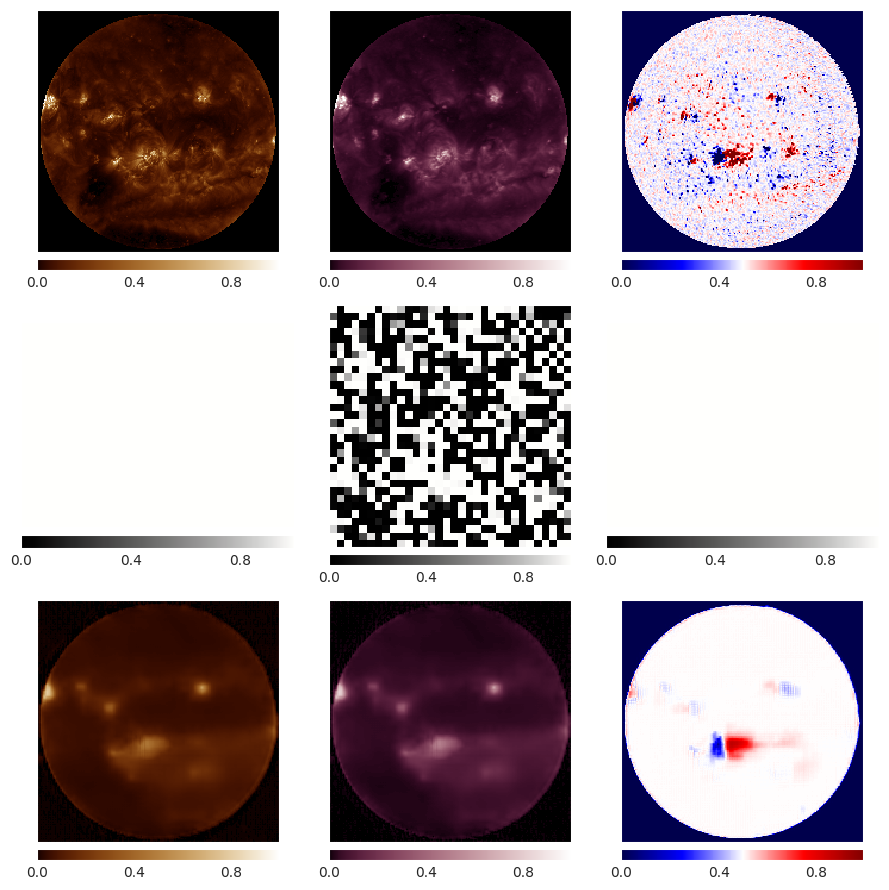

In [179]:
gen_input.take_all = True
test_img = gen_input.sample(1)
code = encoder(test_img)
decoded = decoder(code)

test_img_channels = [i for i in test_img[0].transpose(2,0,1)]


code = (utils.square_dims_vector(np.asarray(code[0])) + 1)/2
code_img = [np.ones((3,4)), code, np.ones((3,4))]
                     
decoded_img_channels = [i for i in np.asarray(decoded[0]).transpose(2,0,1)]

isns.ImageGrid(
    test_img_channels+code_img+decoded_img_channels,
    cmap=["sdoaia193", "sdoaia211", "seismic"] + ["gray"]*3 + ["sdoaia193", "sdoaia211", "seismic"],
    orientation="h",
    vmin=0, 
    vmax=1
)

In [41]:
dataset_dates = [datetime.datetime.strptime(i.stem, "%Y-%m-%dT%H-%M-%S") for i in gen_input.file_list]
dataset_dates

metadata = pd.DataFrame(columns=["dataset_idx", "datetime", "is_fast_wind"])
metadata["dataset_idx"] = list(range(len(metadata)))
metadata["datetime"] = dataset_dates
metadata["datetime"] = metadata["datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")
metadata

,dataset_idx,datetime,is_fast_wind
0,NaN,2016-07-17 01:30:08,NaN
1,NaN,2014-07-03 06:23:06,NaN
2,NaN,2019-02-04 02:30:14,NaN
3,NaN,2018-08-25 08:13:42,NaN
4,NaN,2012-12-07 20:38:48,NaN
...,...,...,...
22496,NaN,2013-02-27 05:08:14,NaN
22497,NaN,2019-04-21 09:13:43,NaN
22498,NaN,2012-10-23 01:51:51,NaN
22499,NaN,2016-07-09 01:30:07,NaN


In [88]:
solar_wind_db = pd.read_csv("./omni_1hr_clean.csv")

solar_wind_db["is_fast_wind"] = (solar_wind_db["V"] > 550).astype(int)
solar_wind_db["datetime"] = pd.to_datetime(solar_wind_db["datetime"], format="%Y-%m-%d %H:%M:%S")
solar_wind_db = solar_wind_db[solar_wind_db["datetime"] >= min(dataset_dates)]
solar_wind_db["datetime"] = solar_wind_db["datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")

solar_wind_db[solar_wind_db["is_fast_wind"] == 1].count()
solar_wind_db = solar_wind_db.dropna()
solar_wind_db

,datetime,BR,BT,BN,V,N,T,is_fast_wind
141772,2012-10-03 04:00:00,-3.3,-0.8,4.6,327.0,8.2,8305.0,0
141773,2012-10-03 05:00:00,-2.5,-0.1,4.5,325.0,10.4,11632.0,0
141774,2012-10-03 06:00:00,-2.4,0.2,3.0,327.0,7.8,16789.0,0
141775,2012-10-03 07:00:00,-0.3,-2.5,-0.4,327.0,8.0,19029.0,0
141776,2012-10-03 08:00:00,1.1,-1.8,-2.3,332.0,6.9,23107.0,0
...,...,...,...,...,...,...,...,...
222812,2021-12-31 20:00:00,-0.6,-2.0,4.2,418.0,7.8,78906.0,0
222813,2021-12-31 21:00:00,-1.3,-2.4,3.4,423.0,8.6,88405.0,0
222814,2021-12-31 22:00:00,1.1,-2.3,1.6,414.0,8.1,95631.0,0
222815,2021-12-31 23:00:00,4.6,-2.8,-3.8,388.0,5.0,68545.0,0


In [100]:
sw_dates = []
for index, row in solar_wind_db.iterrows():
    measurement_date = datetime.datetime.strptime(row["datetime"], "%Y-%m-%d %H:%M:%S")

    wind_delay = (ac.au / (row["V"] * (u.km/u.s))).decompose()
    wind_delay = datetime.timedelta(seconds=wind_delay.value)

    photo_delay = (ac.au / ac.c).decompose()
    photo_delay = datetime.timedelta(seconds=photo_delay.value)

    origin_date = measurement_date - wind_delay + photo_delay
    sw_dates.append(origin_date)

for idx, date_sw_str in tqdm(enumerate(metadata["datetime"]), total=len(metadata)):
    date_sw = datetime.datetime.strptime(date_sw_str, "%Y-%m-%d %H:%M:%S")
    date_dist = [abs(date_sw - i) for i in sw_dates]
    if min(date_dist) < datetime.timedelta(hours=4):
        date_idx = date_dist.index(min(date_dist))
        metadata.at[idx, "is_fast_wind"] = solar_wind_db.iloc[date_idx]["is_fast_wind"]

        
metadata_cpy = metadata.copy()
metadata_cpy.dropna()
metadata_cpy

# min([datetime.datetime.strptime(i.stem, "%Y-%m-%dT%H-%M-%S") for i in gen_input.file_list]), min([datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S") for i in metadata["datetime"]])
# min([i for i in gen_input.file_list]), min(metadata["datetime"])

  0%|          | 0/22501 [00:00<?, ?it/s]

,dataset_idx,datetime,is_fast_wind
0,0,2016-07-17 01:30:08,0
1,1,2014-07-03 06:23:06,0
2,2,2019-02-04 02:30:14,0
3,3,2018-08-25 08:13:42,0
4,4,2012-12-07 20:38:48,0
...,...,...,...
22496,22496,2013-02-27 05:08:14,0
22497,22497,2019-04-21 09:13:43,0
22498,22498,2012-10-23 01:51:51,0
22499,22499,2016-07-09 01:30:07,0


In [69]:
metadata.to_csv("is_fast_solar_wind.csv")
metadata

,dataset_idx,datetime,is_fast_wind
0,0,2016-07-17 01:30:08,0
1,1,2014-07-03 06:23:06,0
2,2,2019-02-04 02:30:14,0
3,3,2018-08-25 08:13:42,0
4,4,2012-12-07 20:38:48,0
...,...,...,...
22496,22496,2013-02-27 05:08:14,0
22497,22497,2019-04-21 09:13:43,0
22498,22498,2012-10-23 01:51:51,0
22499,22499,2016-07-09 01:30:07,1


In [70]:
metadata[metadata["is_fast_wind"] == 1].count()

dataset_idx     1993
datetime        1993
is_fast_wind    1993
dtype: int64

In [169]:
dim_reducer = umap.UMAP(
    n_components=3, 
    n_neighbors=15,
    metric='minkowski', 
    verbose=True, 
    n_epochs=5000, 
    target_metric='euclidean',
    learning_rate=1.0,
    negative_sample_rate=20
)

In [137]:
codes.shape
# codes = np.empty((len(gen_input.file_list), latent_size))
# for idx, val in enumerate(gen_input):
#     codes[batch_size*idx:batch_size*(idx+1)] = encoder.predict(val[0])

(22501, 1024)

In [170]:
dim_reducer.fit(codes)

UMAP(metric='minkowski', n_components=3, n_epochs=5000, negative_sample_rate=100, target_metric='euclidean', verbose=True)
Fri Apr 28 23:16:28 2023 Construct fuzzy simplicial set
Fri Apr 28 23:16:28 2023 Finding Nearest Neighbors
Fri Apr 28 23:16:28 2023 Building RP forest with 13 trees
Fri Apr 28 23:16:28 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Apr 28 23:16:29 2023 Finished Nearest Neighbor Search
Fri Apr 28 23:16:29 2023 Construct embedding


Epochs completed:   0%|            0/5000 [00:00]

Fri Apr 28 23:27:18 2023 Finished embedding


UMAP(metric='minkowski', n_components=3, n_epochs=5000, negative_sample_rate=100, target_metric='euclidean', verbose=True)

In [171]:
sample_idx = random.sample(range(len(codes)), 900)
metadata_sample = metadata.iloc[sample_idx]
data_points = codes[sample_idx]

# metadata_sample = metadata
# data_points = codes


projection = dim_reducer.transform(data_points)
projection.shape, projection.min(), projection.max()

Fri Apr 28 23:27:18 2023 Worst tree score: 0.91035954
Fri Apr 28 23:27:18 2023 Mean tree score: 0.91591143
Fri Apr 28 23:27:18 2023 Best tree score: 0.92169237
Fri Apr 28 23:27:18 2023 Forward diversification reduced edges from 337515 to 76396
Fri Apr 28 23:27:18 2023 Reverse diversification reduced edges from 76396 to 76395
Fri Apr 28 23:27:18 2023 Degree pruning reduced edges from 59478 to 59478
Fri Apr 28 23:27:18 2023 Resorting data and graph based on tree order
Fri Apr 28 23:27:18 2023 Building and compiling search function


/home/eugeniolr/.local/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Epochs completed:   0%|            0/1666 [00:00]

((900, 3), -49.585915, 67.480225)

In [172]:
point_cloud = projection

normals = (point_cloud - [np.mean(point_cloud, axis=0) for _ in point_cloud])
colors = (point_cloud + [[0.5,0.5,0.5] for _ in point_cloud])/1
print(colors)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud[:,:3])
pcd.colors = o3d.utility.Vector3dVector(colors)
pcd.normals = o3d.utility.Vector3dVector(normals)

# mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, .6)
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
    pcd, 
    depth=8, 
    width=0, 
    scale=1.1, 
    linear_fit=False
)[0]

mesh.compute_triangle_normals()
mesh.compute_vertex_normals()
bbox = pcd.get_axis_aligned_bounding_box()
p_mesh_crop = mesh.crop(bbox)

verts = np.asarray(mesh.vertices)
tris = np.asarray(mesh.triangles)


[[ 15.51819038  33.87507629 -34.11922073]
 [ 24.18107986  40.49585724 -19.95095062]
 [ 20.54919243  -0.963552    53.69918442]
 ...
 [-14.07217979  23.73357964  26.70233345]
 [-19.00383949  27.52157402  12.04739475]
 [ -6.90832281 -19.19441795 -17.67782593]]


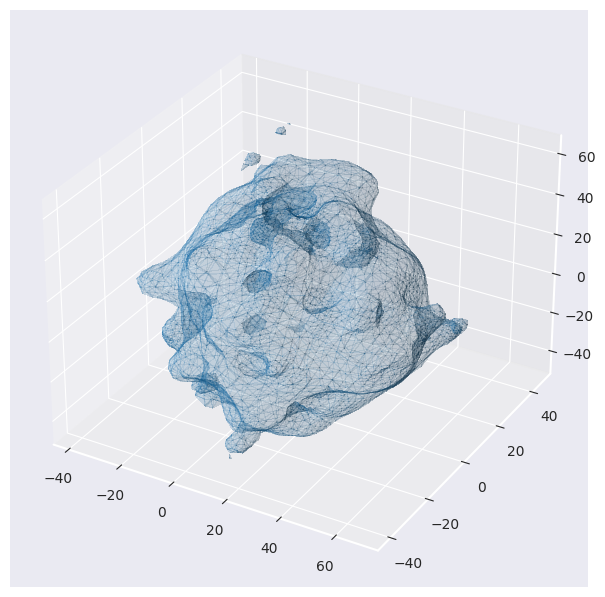

In [173]:
%matplotlib widget

# display_styles = ['Scatter', '3D model', '3D and scatter']
display_styles = ['3D model', 'Scatter', '3D and scatter']

style_selector = widgets.Dropdown(options=display_styles, description='Select display style:')
style = style_selector.value

fig = None
ax = None
cbar = None

def make_plot(style):
    global ax, fig, cbar
    created_new = False
    if not ax or not fig:
        fig = plt.figure(figsize=(7.5, 7.5))
        ax = fig.add_subplot(111, projection='3d')
        created_new = True
    else:
        ax.clear()
        if cbar:
            cbar.remove()
    
    if style == '3D model' or style == '3D and scatter':
        ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=tris,
                            shade=True, alpha=.1, antialiased=False, linewidth=0)

    if style == 'Scatter' or style == '3D and scatter':
        p = ax.scatter(projection[:,0], projection[:,1], projection[:,2], c=metadata_sample['is_fast_wind'], 
                       s=1.0 if style == '3D and scatter' else 10.0, cmap="bwr")
        cbar = fig.colorbar(p);
        cbar.ax.set_ylabel('Predicted speed (km/s)')
        cbar.ax.set_ylabel('Value in the 4$^{th}$ dimension')
    
    if created_new:
        plt.show()
    
def on_style_change(change):
    global style
    style = change.new
    make_plot(style)

style_selector.observe(on_style_change, names='value')
display(widgets.HBox([style_selector]))
make_plot(style)
